**Author:** Raoul Malm  

**Description:** 

This notebook demonstrates the future price prediction for different stocks using recurrent neural networks in tensorflow. Recurrent neural networks with basic, LSTM or GRU cells are implemented. 

**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Analyze data](#2-bullet)
3. [Manipulate data](#3-bullet)
4. [Model and validate data](#4-bullet)
5. [Predictions](#5-bullet)

**Reference:**  

[LSTM_Stock_prediction-20170507 by BenF](https://www.kaggle.com/benjibb/lstm-stock-prediction-20170507/notebook)

# 1. Libraries and settings <a class="anchor" id="1-bullet"></a> 

In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 


/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/zen/opt/anaconda3/envs/envloop

# 2. Analyze data <a class="anchor" id="2-bullet"></a> 
- load stock prices from prices-split-adjusted.csv
- analyze data

In [2]:
df_raw = pd.read_parquet('LTC-USDT.parquet')

df_raw.drop([ 'volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'],1,inplace=True)
df_raw.info()
df_raw.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1595426 entries, 2017-12-13 03:32:00 to 2020-12-29 23:59:00
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    1595426 non-null  float32
 1   high    1595426 non-null  float32
 2   low     1595426 non-null  float32
 3   close   1595426 non-null  float32
dtypes: float32(4)
memory usage: 36.5 MB


,open,high,low,close
open_time,,,,
2017-12-13 03:32:00,272.0,272.0,272.0,272.0
2017-12-13 03:33:00,272.0,272.0,272.0,272.0
2017-12-13 03:34:00,272.0,272.0,272.0,272.0
2017-12-13 03:35:00,272.0,272.0,272.0,272.0
2017-12-13 03:36:00,272.0,272.0,272.0,272.0


In [3]:
def convert_to_Xmin(df, minutes):
    
    df = df.reset_index().groupby(pd.Grouper(key='open_time', 
                                             freq='{minutes}min'.format(minutes=minutes)
                                            )
                                 ).agg({'open': 'first',
                                         'high': 'max',
                                         'low' : 'min',
                                         'close':'last'})
    return df
    
    
    

In [4]:
df_convert = convert_to_Xmin(df_raw, 10).copy(deep=True)
# df_convert = df_raw

In [5]:
df_keep_away = df_convert[-300:].copy(deep=True)

In [6]:
df = df_convert[:-300].copy(deep=True)

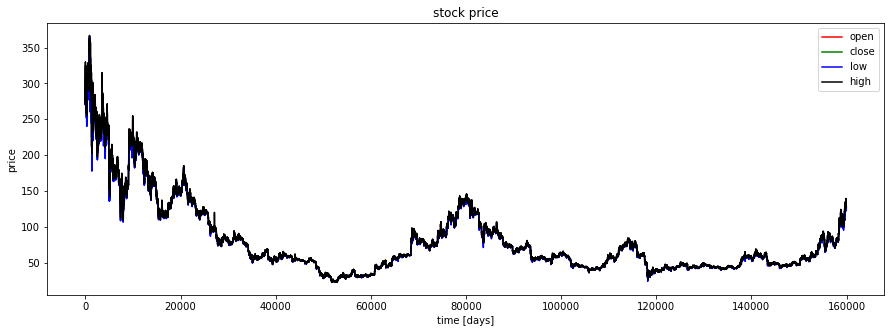

In [7]:
plt.figure(figsize=(15, 5));
plt.plot(df.open.values, color='red', label='open')
plt.plot(df.close.values, color='green', label='close')
plt.plot(df.low.values, color='blue', label='low')
plt.plot(df.high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
plt.show()


# 3. Manipulate data <a class="anchor" id="3-bullet"></a> 
- choose a specific stock
- drop feature: volume
- normalize stock data
- create train, validation and test data sets

In [8]:
# function for min-max normalization of stock
def normalize_data(df, save_values = False):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    opens = df.open.values.reshape(-1,1)
    lows = df.low.values.reshape(-1,1)
    highs = df.high.values.reshape(-1,1)
    closes = df['close'].values.reshape(-1,1)
    scale = min_max_scaler.fit(opens + highs + lows) # + closes)
    df['open'] = scale.transform(opens)
    df['high'] = scale.transform(highs)
    df['low'] = scale.transform(lows)
    df['close'] = scale.transform(closes)
    
    if save_values:
        print("""df, (scale.data_min_, scale.data_max_, scale.min_, scale.scale_ )""")
        return df, (scale.data_min_, scale.data_max_, scale.min_, scale.scale_ )
    
    else:
        return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


class scalling_training_data:
    """
    Must use the same value that was used to normalise the trianing data
    
    https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
    
    
    Class has 2 mathods:
    
    1. scale_data(self, df)
    
        using X_scaled = (X - X_min) / (X_max - X_min),
        returns df that's scaled using self attributes
        
        
    2. rescale_back_data(self, df)
    
        using X_origin = X_scaled * (X_max - X_min) + X_min
        to return the original value after scaled   
    
    """
    
    def __init__(self, s_max_, s_min_, s_scale_, s_scaled_min_):
        self.s_max_ = s_max_
        self.s_min_ = s_min_
        self.s_range_ = self.s_max_ - self.s_min_
        self.s_scale_ = s_scale_
        self.s_scaled_min_ = s_scaled_min_
        
        
    def scale_data(self, df):
        """
        using X_scaled = (X - X_min) / (X_max - X_min),
        returns df that's scaled using self attributes
        """
        
        df = (df - self.s_min_)/self.s_range_
        
        return df
    
    def rescale_back_data(self, df):
        
        df = df * self.s_range_ + self.s_min_
        
        return df
    
# normalize stock
df_stock_norm = df.copy()
df_stock_norm, saved_scale_values = normalize_data(df_stock_norm, save_values=True)

# save scaling values for reuse
d_min_, d_max_, d_scaled_min_, d_scale_ = saved_scale_values
training_scalling = scalling_training_data(s_max_=d_max_[0],
                                           s_min_=d_min_[0],
                                           s_scale_=d_scale_[0],
                                           s_scaled_min_=d_scaled_min_[0])

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)


df, (scale.data_min_, scale.data_max_, scale.min_, scale.scale_ )
x_train.shape =  (127945, 19, 4)
y_train.shape =  (127945, 4)
x_valid.shape =  (15993, 19, 4)
y_valid.shape =  (15993, 4)
x_test.shape =  (15993, 19, 4)
y_test.shape =  (15993, 4)


In [9]:
df_stock_norm

,open,high,low,close
open_time,,,,
2017-12-13 03:30:00,0.198396,0.201312,0.198396,0.201312
2017-12-13 03:40:00,0.201312,0.213946,0.201312,0.206171
2017-12-13 03:50:00,0.206162,0.207143,0.202284,0.202284
2017-12-13 04:00:00,0.202284,0.210156,0.201798,0.201798
2017-12-13 04:10:00,0.201798,0.207075,0.197425,0.197425
...,...,...,...,...
2020-12-27 21:10:00,0.056815,0.056980,0.054794,0.055212
2020-12-27 21:20:00,0.055202,0.057641,0.054444,0.056086
2020-12-27 21:30:00,0.056096,0.060110,0.055989,0.058963


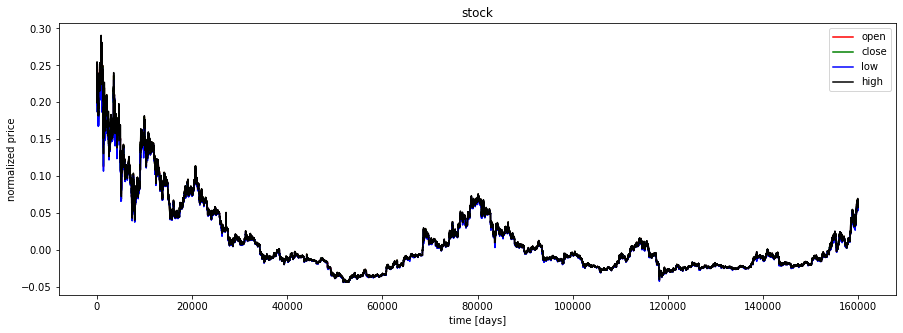

In [10]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='close')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')
plt.show()

# 4. Model and validate data <a class="anchor" id="4-bullet"></a> 
- RNNs with basic, LSTM, GRU cells


In [11]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4
n_neurons = 1 # 200
n_outputs = 4
n_layers = 1 # 2
learning_rate = 0.01
batch_size = 50
n_epochs = 1 # 100
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

X = tf.compat.v1.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.compat.v1.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.compat.v1.nn.rnn_cell.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]


Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [12]:
multi_layer_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

# saver = tf.train.Saver()

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.


In [13]:
# run graph
with tf.compat.v1.Session() as sess: 
    sess.run(tf.compat.v1.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
#             if mse_train != 0:
#                 print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(iteration*batch_size/train_set_size, mse_train))
#                 break
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
#     saver.save(sess, 'BasicRNN_30min_LTCUSDT')

0.00 epochs: MSE train/valid = nan/nan


# 5. Predictions <a class="anchor" id="5-bullet"></a> 

In [14]:
y_train.shape

(1276084, 4)

correct sign prediction for close - open price for train/valid/test: 0.72/0.72/0.75


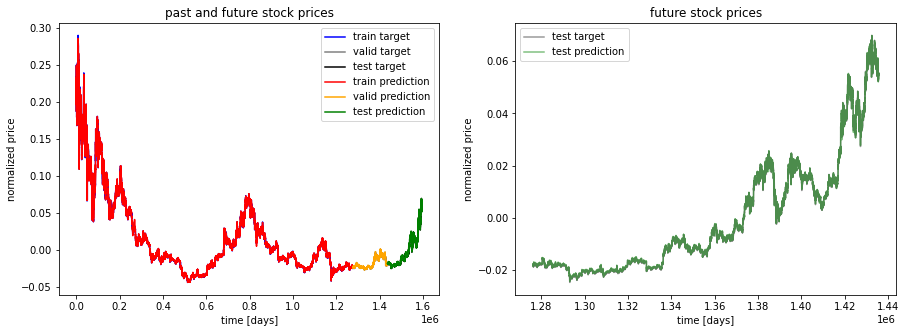

In [15]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target', alpha=0.4)

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction', alpha=0.5)

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))


In [16]:
df_keep_away_scaled = training_scalling.scale_data(df_keep_away).copy(deep=True)

In [17]:
df_keep_away_scaled

,open,high,low,close
open_time,,,,
2020-12-29 19:00:00,0.054960,0.055125,0.054902,0.055096
2020-12-29 19:01:00,0.055086,0.055096,0.054902,0.054999
2020-12-29 19:02:00,0.055009,0.055077,0.054844,0.055018
2020-12-29 19:03:00,0.054989,0.055513,0.054989,0.055445
2020-12-29 19:04:00,0.055435,0.055494,0.055222,0.055416
...,...,...,...,...
2020-12-29 23:55:00,0.060293,0.060342,0.060187,0.060264
2020-12-29 23:56:00,0.060245,0.060264,0.060129,0.060167
2020-12-29 23:57:00,0.060158,0.060187,0.059847,0.059906


In [18]:
x_test[:1, :, :].shape

(1, 19, 4)

In [19]:
x_unseen = []

In [20]:
for i in np.arange(len(df_keep_away_scaled) - 19):## no need to do -1 here as we can keep the last one as testing
    x_unseen.append(df_keep_away_scaled[i: i + 19].values) #.reshape(1,19,4))
    
x_unseen = np.array(x_unseen)

In [21]:
np.array(x_unseen[-1])

array([[0.05992495, 0.05998313, 0.05952739, 0.05969223],
       [0.05973102, 0.05988617, 0.05970193, 0.05977951],
       [0.05977951, 0.05992495, 0.05975042, 0.05990555],
       [0.05989586, 0.06002192, 0.05981829, 0.06002192],
       [0.06002192, 0.06003161, 0.05985707, 0.05999283],
       [0.05997343, 0.06013827, 0.05996373, 0.06009948],
       [0.06009948, 0.06016736, 0.06002192, 0.06010919],
       [0.06011888, 0.06027403, 0.06005101, 0.06025463],
       [0.06028372, 0.06060371, 0.06028372, 0.06054553],
       [0.06054553, 0.06061341, 0.06029342, 0.06043887],
       [0.06044856, 0.06045827, 0.05992495, 0.06003161],
       [0.06002192, 0.06056493, 0.05991526, 0.06048735],
       [0.06050675, 0.06052613, 0.06026433, 0.06029342],
       [0.06030311, 0.06045827, 0.06021585, 0.06024494],
       [0.06028372, 0.06036129, 0.06019645, 0.06025463],
       [0.06029342, 0.06034189, 0.06018676, 0.06026433],
       [0.06024494, 0.06026433, 0.06012858, 0.06016736],
       [0.06015767, 0.06018676,

In [22]:
with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('BasicRNN_30min_LTCUSDT.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    
    y_unseen = sess.run(outputs, feed_dict={X: x_test[:1, :, :]})
    y_unseen2 = sess.run(outputs, feed_dict={X: df_keep_away_scaled[:19].values.reshape(1,19,3)})
    y_unseen_all = sess.run(outputs, feed_dict={X: x_unseen})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./BasicRNN_30min_LTCUSDT


FailedPreconditionError: Attempting to use uninitialized value dense/kernel
	 [[node dense/kernel/read (defined at <ipython-input-12-f864abb4aa13>:5) ]]

Caused by op 'dense/kernel/read', defined at:
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
    handle._run()
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 381, in dispatch_queue
    yield self.process_one()
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2877, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2922, in _run_cell
    return runner(coro)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3146, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-f864abb4aa13>", line 5, in <module>
    stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/layers/core.py", line 188, in dense
    return layer.apply(inputs)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1227, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/layers/base.py", line 530, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 538, in __call__
    self._maybe_build(inputs)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1603, in _maybe_build
    self.build(input_shapes)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py", line 949, in build
    trainable=True)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/layers/base.py", line 435, in add_weight
    getter=vs.get_variable)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 349, in add_weight
    aggregation=aggregation)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/training/checkpointable/base.py", line 607, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 1479, in get_variable
    aggregation=aggregation)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 1220, in get_variable
    aggregation=aggregation)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 547, in get_variable
    aggregation=aggregation)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 499, in _true_getter
    aggregation=aggregation)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 911, in _get_single_variable
    aggregation=aggregation)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 213, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 176, in _variable_v1_call
    aggregation=aggregation)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 155, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 2495, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 217, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 1395, in __init__
    constraint=constraint)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 1557, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 81, in identity
    ret = gen_array_ops.identity(input, name=name)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3890, in identity
    "Identity", input=input, name=name)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value dense/kernel
	 [[node dense/kernel/read (defined at <ipython-input-12-f864abb4aa13>:5) ]]


In [ ]:
y_unseen

In [ ]:
x_unseen

In [ ]:
df_keep_away_scaled

In [ ]:
x_unseen.shape

In [ ]:
y_unseen_all.shape

In [ ]:
df_keep_away_scaled.shape

In [ ]:
y_unseen_predict = pd.DataFrame(y_unseen_all, columns=['u_open','u_high','u_low'])

In [ ]:
y_unseen_predict

In [ ]:
df_compare = df_keep_away_scaled[19:].copy(deep=True)

In [ ]:
df_compare = df_compare.reset_index().merge(y_unseen_predict, left_index=True, right_index=True, how='outer').set_index('open_time')

In [ ]:
df_compare = BTCUSDT_Scale_train1.rescale_back_data(df_compare)

In [ ]:
df_compare[['low','u_low']][-500:].plot(figsize=(20,20))

In [ ]:
df_compare[['high','u_high']][-300:].plot(figsize=(20,20))

In [ ]:
df_compare[['open','u_open']][-300:].plot(figsize=(20,20))